<a href="https://colab.research.google.com/github/cgyireh1/Chatbot_project/blob/main/notebook/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Chatbot
This project involves developing a **Medical Chatbot** using **MedQuad dataset (Medical Question-Answer)** from [kaggle](https://www.kaggle.com/datasets/thedevastator/comprehensive-medical-q-a-dataset/datahttps://www.kaggle.com/datasets/thedevastator/comprehensive-medical-q-a-dataset/data). The dataset includes questions about treatments, chronic diseases, medical protocols, and answers from healthcare professionals such as doctors, nurses, and pharmacists.

The aims of the project is to assist patients by providing reliable medical information and supporting healthcare professionals by automating responses to common medical inquiries.

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

## Importing Libraries

In [ ]:
import re
import nltk
import json
import torch
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from transformers import BertTokenizer, BertModel
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, f1_score

## Data Inspection

* Load data
* Print columns
* Print dataset shape (Data size)
* Check for missing data
* Display first few rows



In [ ]:
# Load your dataset
file_path = '/content/drive/MyDrive/MyModels/chatbot/Medical_Q&A_Dataset.csv'
df = pd.read_csv(file_path)

print("Columns in the dataset:")
print(df.columns, '\n')

print("shape of the dataset:")
print(df.shape, '\n')

print("Basic Info:")
print(df.info(), '\n')

# Check for missing data
print("\nMissing data:")
df.isnull().sum()

Columns in the dataset:
Index(['qtype', 'Question', 'Answer'], dtype='object') 

shape of the dataset:
(16407, 3) 

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qtype     16407 non-null  object
 1   Question  16407 non-null  object
 2   Answer    16407 non-null  object
dtypes: object(3)
memory usage: 384.7+ KB
None 


Missing data:


,0
qtype,0
Question,0
Answer,0


In [ ]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text


df['Question'] = df['Question'].apply(preprocess)
df['Answer'] = df['Answer'].apply(preprocess)
df.head()

,qtype,Question,Answer
0,susceptibility,who is at risk for lymphocytic choriomeningiti...,lcmv infections can occur after exposure to fr...
1,symptoms,what are the symptoms of lymphocytic choriomen...,lcmv is most commonly recognized as causing ne...
2,susceptibility,who is at risk for lymphocytic choriomeningiti...,individuals of all ages who come into contact ...
3,exams and tests,how to diagnose lymphocytic choriomeningitis lcm,during the first phase of the disease the most...
4,treatment,what are the treatments for lymphocytic chorio...,aseptic meningitis encephalitis or meningoence...


In [ ]:
# Loading the BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

intents = []
# Store question embeddings for similarity search
question_embeddings = []

for ind in df.index:
    question = df['Question'][ind].lower().strip()
    answer = df['Answer'][ind]
    qtype = df['qtype'][ind]
    intents.append({'qtype': qtype, 'question': question, 'answer': answer})

# Saving the intents
with open("med_quad.json", "w") as f:
    json.dump({'intents': intents}, f)

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Prepare the training data
words = []
classes = []
documents = []
lemmatizer = WordNetLemmatizer()
ignore_letters = ['?', '!', '.', ',']

for intent in intents:
    pattern = intent['question']
    words.extend(tokenizer.tokenize(pattern))
    documents.append((pattern, intent['qtype']))
    if intent['qtype'] not in classes:
        classes.append(intent['qtype'])
    question_embeddings.append(get_bert_embedding(pattern))

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [ ]:
# data training
question_embeddings = np.array(question_embeddings)

training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    embedding = get_bert_embedding(document[0])
    output_row = label_binarizer.transform([document[1]])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

### Model Definition, Training, and Saving

In [ ]:
import tensorflow as tf
# Define model
model = Sequential()
model.add(Dense(128, input_shape=(train_x.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(train_y.shape[1], activation='softmax'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
# Compile & train
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

plot_model(model, to_file='model2.png', show_shapes=True)

hist = model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)
model.save('chatbotmodel.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,296 (426.94 KB)

 Trainable params: 109,296 (426.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4003 - loss: 2.0065
Epoch 2/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8337 - loss: 0.6815
Epoch 3/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9461 - loss: 0.2817
Epoch 4/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9684 - loss: 0.1657
Epoch 5/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9811 - loss: 0.1057
Epoch 6/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9848 - loss: 0.0809
Epoch 7/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9873 - loss: 0.0653
Epoch 8/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9909 - loss: 0.0553
Epoch 9/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9919 - loss: 0.0476
Epoch 10/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9920 - loss: 0.0379
Epoch 11/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9938 - loss: 0.0323
Epoch 12/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

## Plotting Training Metrics

A visualization of the training performance of the model using the  **accuracy** and **loss** over epochs.

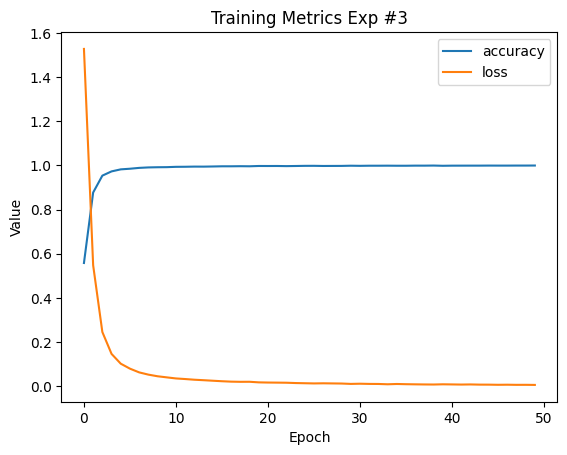

In [ ]:
import matplotlib.pyplot as plt

# Plot the training metrics
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.title('Training Metrics Exp #3')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Evaluate model
y_pred = np.argmax(model.predict(train_x), axis=1)
y_true = np.argmax(train_y, axis=1)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(y_true, y_pred))


513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9997
F1 Score: 0.9997
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      0.98      0.99        46
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       653
           4       1.00      1.00      1.00      1120
           5       1.00      1.00      1.00      1087
           6       1.00      1.00      1.00      4535
           7       1.00      1.00      1.00      1446
           8       1.00      1.00      1.00       361
           9       0.99      1.00      0.99       210
          10       1.00      1.00      1.00       395
          11       1.00      1.00      1.00        77
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00       324
          14       1.00      1.00      1.00      2748
          15       1.00      1.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Response Prediction

In [ ]:
# Response prediction and intent prediction
def prediction_class(sentence):
    embedding = get_bert_embedding(sentence)
    embedding = np.reshape(embedding, (1, -1))  # Reshaping to match the model input shape
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list


# get response function
def get_response(intents_list):
    if not intents_list:
        return "Sorry, I don't understand."
    tag = intents_list[0]['intent']
    print(f"Intent detected: {tag}")
    for intent in intents:
        if intent['qtype'] == tag:
            print(f"Response: {intent['answer']}")
            return intent['answer']
    return "Sorry, this is out of my knowledge base."


In [ ]:
# Chatbot interaction
model = load_model('chatbotmodel.keras')
print("Hi! I'm your medical chatbot. What medical question can I help with?")

while True:
    message = input("You: ")
    if message.lower() in ['quit', 'exit']:
        print("Was nice interacting with you 🫶")
        break
    ints = prediction_class(message)
    response = get_response(ints)
    print(f"Bot: {response}")


In [ ]:
# import re
# import nltk
# import json
# import torch
# import random
# import pickle
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from nltk.stem import WordNetLemmatizer
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense, Dropout
# from sklearn.preprocessing import LabelBinarizer
# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import Trainer, TrainingArguments
# from sklearn.metrics import classification_report, accuracy_score, f1_score
# import tensorflow as tf


# # Load the dataset
# file_path = '/content/drive/MyDrive/MyModels/chatbot/Medical_Q&A_Dataset.csv'
# df = pd.read_csv(file_path)

# # Data inspection
# print("Columns in the dataset:", df.columns)
# print("Shape of the dataset:", df.shape)
# print("Basic Info:")
# print(df.info())

# # Check for missing data
# print("\nMissing data:", df.isnull().sum())

# # Display first few rows
# print("\nFirst 5 rows of the dataset:")
# print(df.head())

# # Data preprocessing function
# def preprocess(text):
#     text = text.lower()
#     text = re.sub('[^A-Za-z0-9 ]+', '', text)
#     return text

# df['Question'] = df['Question'].apply(preprocess)
# df['Answer'] = df['Answer'].apply(preprocess)

# # Load BERT tokenizer & model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['qtype'].unique()))

# # Prepare intents and embeddings
# intents = []
# question_embeddings = []

# for ind in df.index:
#     question = df['Question'][ind].lower().strip()
#     answer = df['Answer'][ind]
#     qtype = df['qtype'][ind]
#     intents.append({'qtype': qtype, 'question': question, 'answer': answer})

# # Save intents to file
# with open("medquad.json", "w") as f:
#     json.dump({'intents': intents}, f)

# # Function to get BERT embeddings
# # Function to get BERT embeddings
# def get_bert_embedding(sentence):
#     # Tokenize and convert to tensor
#     inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
#     # Get the hidden states from BERT
#     with torch.no_grad():
#         outputs = bert_model(**inputs)

#     # Extract the [CLS] token embedding (first token of each sequence)
#     cls_embedding = outputs.logits  # for classification
#     return cls_embedding.squeeze().numpy()  # Convert to numpy array



# # Prepare the training data
# words = []
# classes = []
# documents = []
# lemmatizer = WordNetLemmatizer()
# ignore_letters = ['?', '!', '.', ',']

# for intent in intents:
#     pattern = intent['question']
#     words.extend(tokenizer.tokenize(pattern))
#     documents.append((pattern, intent['qtype']))
#     if intent['qtype'] not in classes:
#         classes.append(intent['qtype'])
#     question_embeddings.append(get_bert_embedding(pattern))

# words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
# words = sorted(set(words))
# classes = sorted(set(classes))

# # Save words and classes to pickle files
# pickle.dump(words, open('words.pkl', 'wb'))
# pickle.dump(classes, open('classes.pkl', 'wb'))

# # Prepare training data
# question_embeddings = np.array(question_embeddings)
# training = []
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(classes)

# for document in documents:
#     embedding = get_bert_embedding(document[0])
#     output_row = label_binarizer.transform([document[1]])[0]
#     training.append((embedding.flatten(), output_row))

# random.shuffle(training)
# training = np.array(training, dtype=object)

# train_x = np.array([item[0] for item in training])
# train_y = np.array([item[1] for item in training])

# # Define the model
# model = Sequential()
# model.add(Dense(128, input_shape=(train_x.shape[1],), activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(train_y.shape[1], activation='softmax'))

# # Compile & train the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

# # Train the model
# history = model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)

# # Save the model
# model.save('chatbot_model.keras')

# # Plot training accuracy and loss
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['loss'], label='loss')
# plt.title('Training Metrics')
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# # Evaluate the model
# y_pred = np.argmax(model.predict(train_x), axis=1)
# y_true = np.argmax(train_y, axis=1)
# accuracy = accuracy_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred, average='weighted')

# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("Classification Report:\n", classification_report(y_true, y_pred))

# # Prediction function
# def prediction_class(sentence):
#     embedding = get_bert_embedding(sentence)
#     embedding = np.reshape(embedding, (1, -1))  # Ensure correct shape
#     res = model.predict(embedding)[0]
#     ERROR_THRESHOLD = 0.5
#     results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
#     results.sort(key=lambda x: x[1], reverse=True)
#     return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
#     return return_list

# # Response matching function
# def get_response(intents_list):
#     if not intents_list:
#         return "Sorry, I don't understand."

#     top_intents = intents_list[:3]  # Get top 3 intents
#     responses = []

#     for intent in top_intents:
#         tag = intent['intent']
#         print(f"Intent detected: {tag}")
#         for intent_data in intents:
#             if intent_data['qtype'] == tag:
#                 responses.append(intent_data['answer'])

#     if responses:
#         return max(responses, key=lambda x: x['probability'])  # choose the response with highest probability
#     return "Sorry, this is out of my knowledge base."

# # Chatbot interaction loop
# print("Hi! I'm your medical chatbot. What medical question can I help with?")
# while True:
#     message = input("You: ")
#     if message.lower() in ['quit', 'exit']:
#         print("Was nice interacting with you 🫶")
#         break
#     intents = prediction_class(message)
#     response = get_response(intents)
#     print(f"Bot: {response}")


In [ ]:
import numpy as np
import random
import json
import pickle
import torch
import gradio as gr
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import load_model
from nltk.stem import WordNetLemmatizer

# Load necessary files
model = load_model('/content/chatbotmodel.keras')
words = pickle.load(open('/content/words.pkl', 'rb'))
classes = pickle.load(open('/content/classes.pkl', 'rb'))
with open("/content/med_quad.json", "r") as json_file:
    dict_ = json.load(json_file)

# Load the BERT tokenizer and model from Hugging Face
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

lemmatizer = WordNetLemmatizer()

# Function to get BERT embeddings
def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Function to predict the intent of a user's input
def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

# Function to get the response based on the intent predicted
def get_response(intents_list, intents_json):
    if intents_list:
        tag = intents_list[0]['intent']  # Get the predicted intent
        for intent in intents_json['intents']:
            if intent['qtype'] == tag:  # Check if intent matches qtype in JSON
                return intent['answer']  # Return the corresponding answer
    return "Sorry, I don't understand."  # Default response if no match

# Function that Gradio will use to provide chatbot responses
def chatbot_response(message):
    intents = predict_class(message)
    response = get_response(intents, dict_)
    return response

# Create the Gradio interface
iface = gr.Interface(
    fn=chatbot_response,
    inputs="text",
    outputs="text",
    title="Healthcare Chatbot",
    description="Hi! I'm your medical chatbot. What medical question can I help with today?",
    theme="huggingface"
)

# Launch the Gradio interface
iface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1096: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67bef66c-47f5280662402df36455f49e;71a82095-b972-4b89-9d1a-41ba894c18b2)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d1002439155385d78d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
